In [1]:


from typing import Any

from gnn_tracking.models.track_condensation_networks import PerfectECGraphTCN
from gnn_tracking.training.dynamiclossweights import NormalizeAt
from gnn_tracking.utils.dictionaries import subdict_with_prefix_stripped
from torch import nn

import numpy as np
from celluloid import Camera

from gnn_tracking_hpo.config import auto_suggest_if_not_fixed, get_metadata
from gnn_tracking_hpo.trainable import TCNTrainable, suggest_default_values

In [2]:
class DynamicTCNTrainable(TCNTrainable):
    def get_loss_functions(self) -> dict[str, Any]:
        return {
            "potential": self.get_potential_loss_function(),
            "background": self.get_background_loss_function(),
        }

    def get_cluster_functions(self) -> dict[str, Any]:
        return {}

    def get_loss_weights(self):
        return subdict_with_prefix_stripped(
            self.tc, "lw",
        )

    def get_model(self) -> nn.Module:
        return PerfectECGraphTCN(
            node_indim=6, edge_indim=4, **subdict_with_prefix_stripped(self.tc, "m_"),
        )
        pass


In [3]:

# def get_config(
# ) -> dict[str, Any]:
#     config = get_metadata()
#
#     def d(key, *args, **kwargs):
#         auto_suggest_if_not_fixed(key, config, None, *args, **kwargs)
#
#     d("sector", 9)
#     d("n_graphs_train", 100)
#     d("n_graphs_val", 10)
#     d("n_graphs_test", 1)
#     d("training_pt_thld", 0.9)
#     d("training_without_noise", True)
#     d("batch_size", 1)
#     d("m_h_outdim", 2)
#     d("m_ec_tnr", 1)
#     d("m_ec_tpr", 1)
#
#     suggest_default_values(config, None, perfect_ec=True)
#     return config

In [17]:
config = {
    "lr": 0.0005655795153563859,
    "sb": 0.12120230680126508,
    "q_min": 0.3611768519294592,
    "m_L_hc": 3,
    "sector": 9,
    "m_e_dim": 5,
    "m_h_dim": 7,
    "m_ec_tnr": 1,
    "m_ec_tpr": 0.8,
    "optimizer": "adam",
    "scheduler": None,
    "batch_size": 1,
    "m_alpha_hc": .9,
    "m_h_outdim": 2,
    "attr_pt_thld": 0.5654455552047115,
    "m_hidden_dim": 116,
    "n_graphs_val": 69,
    "n_graphs_test": 1,
    "n_graphs_train": 300,
    "rlw_background": 1,
    "training_pt_thld": 0.9,
    "training_without_noise": True,
    "lw_potential_repulsive": 1e1,
    "lw_potential_attractive": 1e6,
    "lw_potential_background": 1e-2,
    "m_interaction_node_hidden_dim": 64,
    "m_interaction_edge_hidden_dim": 64,
    "repulsive_radius_threshold": 2.,
}
config.update(get_metadata())
suggest_default_values(config, None, perfect_ec=True)

In [18]:
import pprint
pprint.pprint(config)

{'attr_pt_thld': 0.5654455552047115,
 'batch_size': 1,
 'gnn_tracking_experiments_hash': '3e12a2e9d710353d43c37e163c7b121a10c49605',
 'gnn_tracking_hash': '92ca9743c80bc79d866cf2c52d86f38645e33ffe',
 'lr': 0.0005655795153563859,
 'lw_potential_attractive': 1000000.0,
 'lw_potential_background': 0.01,
 'lw_potential_repulsive': 10.0,
 'm_L_hc': 3,
 'm_alpha_hc': 0.9,
 'm_e_dim': 5,
 'm_ec_tnr': 1,
 'm_ec_tpr': 0.8,
 'm_h_dim': 7,
 'm_h_outdim': 2,
 'm_hidden_dim': 116,
 'm_interaction_edge_hidden_dim': 64,
 'm_interaction_node_hidden_dim': 64,
 'n_graphs_test': 1,
 'n_graphs_train': 300,
 'n_graphs_val': 69,
 'optimizer': 'adam',
 'q_min': 0.3611768519294592,
 'repulsive_radius_threshold': 2.0,
 'rlw_background': 1,
 'sb': 0.12120230680126508,
 'scheduler': None,
 'sector': 9,
 'test': False,
 'training_pt_thld': 0.9,
 'training_without_noise': True}


In [19]:
from gnn_tracking.training.tcn_trainer import TCNTrainer
from torch_geometric.data import Data


class FixedDataLatentSpacePlotCollector:
    def __init__(self, data: Data, apply_truth_cuts=True):
        """This hook for collecting data for latent space animations
        is the most precise/detailed one, because it evaluates one
        graph after every single batch.
        The downside: It slows down training significantly because it
        doubles the evaluations that need to be done.

        Args:
            data:
            apply_truth_cuts:
        """
        self.latent_spaces = []
        self.pid = None
        self.epochs = []
        self.batch_indices = []
        self.data = data
        self.apply_truth_cuts = apply_truth_cuts
        self.batch_losses = []

    @staticmethod
    def should_snapshot(epoch: int, batch: int) -> bool:
        """Implement this to avoid performance degradation by
        only taking snapshot every nth epoch/batch
        """
        if epoch <= 2 and (batch % 3) != 0:
            return False
        if epoch >= 2 and (batch % 40) != 0:
            return False
        return True

    def __call__(self, trainer: TCNTrainer, epoch: int, batch_index: int, model_output: int, data: Data):
        if not self.should_snapshot(epoch, batch_index):
            return
        test_model_output = trainer.evaluate_model(self.data, apply_truth_cuts=self.apply_truth_cuts)
        self.batch_losses.append(trainer.get_batch_losses(test_model_output))
        if self.pid is None:
            self.pid = test_model_output["particle_id"]
        self.latent_spaces.append(test_model_output["x"].detach().cpu().numpy())
        self.epochs.append(epoch)
        self.batch_indices.append(batch_index)

In [36]:
trainable = DynamicTCNTrainable(config)
trainer = trainable.trainer

DEBUG: Got config
{'attr_pt_thld': 0.5654455552047115,
 'batch_size': 1,
 'gnn_tracking_experiments_hash': '3e12a2e9d710353d43c37e163c7b121a10c49605',
 'gnn_tracking_hash': '92ca9743c80bc79d866cf2c52d86f38645e33ffe',
 'lr': 0.0005655795153563859,
 'lw_potential_attractive': 1000000.0,
 'lw_potential_background': 0.01,
 'lw_potential_repulsive': 10.0,
 'm_L_hc': 3,
 'm_alpha_hc': 0.9,
 'm_e_dim': 5,
 'm_ec_tnr': 1,
 'm_ec_tpr': 0.8,
 'm_h_dim': 7,
 'm_h_outdim': 2,
 'm_hidden_dim': 116,
 'm_interaction_edge_hidden_dim': 64,
 'm_interaction_node_hidden_dim': 64,
 'n_graphs_test': 1,
 'n_graphs_train': 300,
 'n_graphs_val': 69,
 'optimizer': 'adam',
 'q_min': 0.3611768519294592,
 'repulsive_radius_threshold': 2.0,
 'rlw_background': 1,
 'sb': 0.12120230680126508,
 'scheduler': None,
 'sector': 9,
 'test': False,
 'training_pt_thld': 0.9,
 'training_without_noise': True}
INFO: Loading data to cpu memory
INFO: Loading 370 graphs (out of 371 available).
DEBUG: Parameters for data loaders: {'

In [37]:
import torch
trainer = trainable.trainer
sel = 5

with torch.no_grad():
    loader = trainer.val_loader
    for idx, data in enumerate(loader):
        if idx < sel:
            continue
        # model_output = trainer.evaluate_model(data, mask_pids_reco=False)
        if idx == sel:
            break

test_data_point = data

In [38]:
collector = FixedDataLatentSpacePlotCollector(data)
trainer.add_hook(collector, "batch")
collector_ntc = FixedDataLatentSpacePlotCollector(data, apply_truth_cuts=False)
trainer.add_hook(collector_ntc, "batch")


In [39]:
# trainer.test_step = lambda *args, **kwargs: {}
trainer.skip_test_during_training = True

In [68]:
for i in range(25):
    trainable.step()

INFO: Training for epoch 43 took 2.39 seconds


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 39.45 GiB total capacity; 38.05 GiB already allocated; 2.25 MiB free; 38.26 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
from functools import partial
from gnn_tracking.postprocessing.dbscanscanner import dbscan_scan

trainer.clustering_functions = {
    "dbscan": partial(dbscan_scan, n_trials=20, n_jobs=12)
}
TCNTrainer.test_step(trainer, apply_truth_cuts=True)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def get_color_mapper(selected_values, colors: Sequence|None=None):
    if colors is None:
        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    if len(selected_values) > len(colors):
        raise ValueError(f"Only up to {len(colors)} values can be selected.")

    cm = np.vectorize(colors.__getitem__)
    vm = np.vectorize({p.item(): i for i, p in enumerate(selected_values)}.get)

    def mapper(values):
        mv = vm(values)
        return cm(mv)

    return mapper

In [ ]:

selected_pids = np.random.choice(collector_ntc.data.particle_id.cpu()[collector_ntc.data.pt.cpu() > 1 & collector_ntc.data.reconstructable.cpu()], 10)
cm = get_color_mapper(selected_pids)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
camera = Camera(fig)
# todo: add if statement here
truth_cut_pids = collector_ntc.data.particle_id.cpu()#[trainer._get_training_mask(collector_ntc.data)[0]]
selected_mask = np.isin(truth_cut_pids.cpu().numpy(), selected_pids)
colors = cm(truth_cut_pids[np.isin(truth_cut_pids.cpu().numpy(), selected_pids)])
from tqdm import tqdm_notebook as tqdm

for latent, epoch, batch in tqdm(list(zip(collector_ntc.latent_spaces, collector_ntc.epochs, collector_ntc.batch_indices))):
    if epoch <= 2 and (batch % 3) != 0:
        continue
    if epoch >= 2 and (batch % 40) != 0:
        continue
    if epoch >= 10 and (batch % 80) != 0:
        continue
    mu = np.mean(latent, axis=0)
    std = np.std(latent, axis=0)
    latent -= mu
    latent /= std
    label = f"epoch={epoch}, batch={batch}"
    ax.scatter(latent[~selected_mask][:, 0], latent[~selected_mask][:, 1], s=2, color="black", alpha=0.5)
    ax.scatter(latent[selected_mask][:, 0], latent[selected_mask][:, 1], s=10, color=colors, alpha=1)
    ax.text(.01, .99, label, ha='left', va='top', transform=ax.transAxes)
    camera.snap()
anim = camera.animate(blit=True, interval=80)
print("saving")
anim.save('scatter_ntc.mp4')
print("done")

In [ ]:
truth_cut_pids.shape

In [ ]:
class AnimateLatentSpaceDynamics:
    def __init__(self, latent_spaces, epochs, batch_indices, pids):
        pass

    @classmethod
    def from_collector(cls):
        pass

In [ ]:
print("test")

In [ ]:
with torch.no_grad():
    model_output = trainer.evaluate_model(collector.data, mask_pids_reco=False)
x = model_output["x"]
pid = model_output["particle_id"]
pt = model_output["pt"]

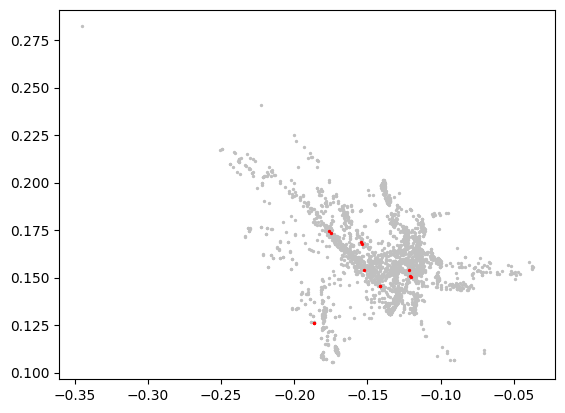

In [121]:

selected_pids = np.random.choice(pid,  1)
# cm = get_color_mapper(selected_pids)
mask = np.isin(pid, selected_pids)
plt.scatter(x[:, 0][~mask], x[:, 1][~mask], s=2, c="silver")
plt.scatter(x[:, 0][mask], x[:, 1][mask], s=2,  c="red")